# 関西CAE 懇話会 & GTC2017ネタ

<教師データ>
case1: 1,2,3,4,5,6,7,8...28.. 1,2,3,4,5,6,7,8...28,(ラベルデータ) 10, 30, 255, 50
case2: 1,2,3,4,5,6,7,8...28 ........ 1,2,3,4,5,6,7,8...28, 1,2,3,4,5,6,7,8...28
:
caseN: 1,2,3,4,5,6,7,8...28 ........ 1,2,3,4,5,6,7,8...28, 1,2,3,4,5,6,7,8...28

# input file for creating training data (教師データを作成するためのinput_files)
yamlで保存されます。

教師データが "1024" ほしいときは　以下のように指定してください。
if you want to get 1024 training datas, you can indicate the following parameters:

```
NUMBER_OF_TRAINING_DATA: 1024
```

壁の境界をどの壁も4等分で境界条件を指定したいときは、下記のようにしてしてください。


```
NUMBER_OF_BOUNDARY_BLOCKS_PER_X_WALL: 4
NUMBER_OF_BOUNDARY_BLOCKS_PER_Y_WALL: 4
```

In [7]:
%%bash
cat << EOF > input.yml
#############################################
# Global Parameters
#############################################
NUMBER_OF_TRAINING_DATA: 100
NUMBER_OF_BOUNDARY_BLOCKS_PER_X_WALL: 4
NUMBER_OF_BOUNDARY_BLOCKS_PER_Y_WALL: 4

##############################################
# Don't touch the following parameters
##############################################
CONVERGENCE_CRITERIA: 0.01
X_SOLVE: 32
Y_SOLVE: 32
X_CUT: 28
Y_CUT: 28
TEMPARATURE_MIN: 0
TEMPARATURE_MAX: 255
X_BOUND: 1
Y_BOUND: 1
EOF
cat input.yml 

#############################################
# Global Parameters
#############################################
NUMBER_OF_TRAINING_DATA: 100
NUMBER_OF_BOUNDARY_BLOCKS_PER_X_WALL: 4
NUMBER_OF_BOUNDARY_BLOCKS_PER_Y_WALL: 4

##############################################
# Don't touch the following parameters
##############################################
CONVERGENCE_CRITERIA: 0.01
X_SOLVE: 32
Y_SOLVE: 32
X_CUT: 28
Y_CUT: 28
TEMPARATURE_MIN: 0
TEMPARATURE_MAX: 255
X_BOUND: 1
Y_BOUND: 1


# Source Code

In [10]:
# coding: utf-8
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import yaml

def initialize_fields(x_size, y_size):
    print("#### initializing ####")
    area = np.zeros((x_size, y_size))
    return area

class SetBoundaryConditions(object):
    def __init__(self, area):
        self.area = area
        self.xlen = len(area[0])
        self.ylen = len(area)
        
    def xdirichlet(self, xarray, xmin, yconst):
        print("#### set: xdirichlet y = ", yconst)
        i = xmin
        for val in xarray[:]:
            self.area[yconst][i] = val
            i += 1
        return self.area[[yconst],:]

    def ydirichlet(self, yarray, xconst, jmin):
        print("#### set: ydirichlet x = ", xconst)
        j = jmin
        for val in yarray[:]:
            self.area[j][xconst] = val  
            j += 1
        return self.area[:,[xconst]]

def diffusion_equation(area, imin, jmin, imax, jmax, convergence_criteria):
    print("#### start: diffusiion equation ####")
    print("imin:", imin)
    print("imax:", imax)
    print("jmin:", jmin)
    print("jmax:", jmax)
    
    sum_now = 0.0
    sum_old = 0.0
    residual_error = 1
    
    iter = 0
    while (residual_error > convergence_criteria):
        for j in range(jmin, jmax):
            for i in range(imin, imax):
                area[j][i] = 0.25 * (area[j][i - 1] + area[j][i + 1] 
                                   + area[j + 1][i] + area[j - 1][i])
                sum_now = sum_now + area[j][i]
        residual_error = abs((sum_now - sum_old) / sum_now)
        sum_old = sum_now
        if iter % 10 == 0:
            print(iter, "residual_error:", residual_error)
        iter += 1
                   
    print("#### end: diffusiion equation")
    
###########################################################
# set the random boudary condition
##########################################################
class SetRandomArray(object):
    def __init__(self, array_size, imin, imax, num_block):
        
        if array_size % num_block != 0:
            sys.stderr.write('\n"array_size % number_of_blocks = 0" is required\n')
            sys.stderr.write('\nPlease change array_size or boundary block number\n')
            sys.exit("１")

        val_in_block = np.zeros(num_block)
        for i in range(num_block):
            val_in_block[i] = random.randint(imin, imax)  

        self.array = np.zeros(array_size)
        block_size = array_size / num_block
        for i in range(array_size):
            j = int(i / block_size)
            self.array[i] = val_in_block[j]
        self.values = val_in_block
        
    def data(self):
        return self.array
    
    def values(self):
        return self.values


def transfer_2d_array_to_1d_array(area, imin, jmin, imax, jmax):
    print("#### transfer_2d_array_to_1d_array ####")
    print("imin:", imin)
    print("imax:", imax)
    print("jmin:", jmin)
    print("jmax:", jmax)
    x_cut_size = imax - imin
    y_cut_size = jmax - jmin
    training_data = np.zeros(x_cut_size * y_cut_size)
    k = 0
    for j in range(jmin, jmax):
        for i in range(imin, imax):
            training_data[k] = '%03.1f' % area[j][i]
            #print(k, training_data[k])
            k += 1
    return training_data

def output_training_data(data, label, outputfile):
    training_data = np.r_[data, label]
    with open(outputfile, 'a') as f:
        writer = csv.writer(f, lineterminator='\n') # 改行コード（\n）を指定しておく
        writer.writerow(training_data)     # list（1次元配列）の場合
    #print("training_data:", training_data)


            
########################################################################
# main
########################################################################

def main(input_data, outputfile):
    
    #############################################
    # READING YAMLFILE (input file)
    #############################################

    # GROBAL VARIABLES
    NUMBER_OF_TRAINING_DATA = input_data['NUMBER_OF_TRAINING_DATA']
    NUMBER_OF_BOUNDARY_BLOCKS_PER_X_WALL = input_data['NUMBER_OF_BOUNDARY_BLOCKS_PER_X_WALL']
    NUMBER_OF_BOUNDARY_BLOCKS_PER_Y_WALL = input_data['NUMBER_OF_BOUNDARY_BLOCKS_PER_Y_WALL']
    CONVERGENCE_CRITERIA = input_data['CONVERGENCE_CRITERIA']
    X_SOLVE = input_data['X_SOLVE']
    Y_SOLVE = input_data['Y_SOLVE']
    X_CUT = input_data['X_CUT']
    Y_CUT = input_data['Y_CUT']
    TEMPARATURE_MIN = input_data['TEMPARATURE_MIN']
    TEMPARATURE_MAX = input_data['TEMPARATURE_MAX']
    X_BOUND = input_data['X_BOUND']
    Y_BOUND = input_data['Y_BOUND']
    
    ###########################################
    # allocating and initializing 2d array
    ###########################################
    
    # all regions including boundary condition
    x_size = X_SOLVE + 2 * X_BOUND
    y_size = Y_SOLVE + 2 * Y_BOUND

    # allocating and initializing 2d array
    area = initialize_fields(x_size, y_size)

    ###########################################
    # seting boundary conditions
    ###########################################
    
    # calc-region excluding boudary condition
    imin = X_BOUND
    imax = x_size - X_BOUND
    jmin = Y_BOUND
    jmax = y_size - Y_BOUND
    
    # boundary condition parameter
    xarray_size = X_SOLVE
    yarray_size = Y_SOLVE
    tmin = TEMPARATURE_MIN
    tmax = TEMPARATURE_MAX
    num_xblock = NUMBER_OF_BOUNDARY_BLOCKS_PER_X_WALL
    num_yblock = NUMBER_OF_BOUNDARY_BLOCKS_PER_Y_WALL
    
    # getting random values for bounddry
    t_wall = SetRandomArray(xarray_size, tmin, tmax, num_xblock)
    b_wall = SetRandomArray(xarray_size, tmin, tmax, num_xblock)    
    l_wall = SetRandomArray(yarray_size, tmin, tmax, num_yblock)     
    r_wall = SetRandomArray(yarray_size, tmin, tmax, num_yblock)

    sbc = SetBoundaryConditions(area)
    
    print("xsize: ", len(area))
    print("ysize: ", len(area[0]))
    
    # setting top boundary
    xstart, yconst = imin, 0
    res = sbc.xdirichlet(t_wall.array, xstart, yconst); #print(res)
    
    # setting bottom boundary
    xstart, yconst = imin, y_size - 1
    res = sbc.xdirichlet(b_wall.array, xstart, yconst); #print(res)
    
    # setting left boundary
    xconst, ystart = 0, jmin
    res = sbc.ydirichlet(l_wall.array, xconst, ystart); #print(res)
    
    # setting right boundary
    xconst, ystart = x_size - 1, jmin
    res = sbc.ydirichlet(r_wall.array, xconst, ystart); #print(res)

    
    ###########################################
    # running solver
    ###########################################
    
    diffusion_equation(area, imin, jmin, imax, jmax, CONVERGENCE_CRITERIA)


    ###########################################
    # output data for deep learning
    ###########################################
    
    # output 28 x 28 area like mnist
    x_offset = int((X_SOLVE - X_CUT) / 2) + X_BOUND
    y_offset = int((Y_SOLVE - Y_CUT) / 2) + Y_BOUND
    
    # transfer 2d-array to 1d-array due to deep learning training data
    data_1d = transfer_2d_array_to_1d_array(area, x_offset, y_offset, x_size - x_offset, y_size - y_offset)
    
    # preparing label for deep learning. this labes is 1d-vector
    tmp_x = np.r_[t_wall.values, b_wall.values]
    tmp_y = np.r_[l_wall.values, r_wall.values]
    label_vector = np.r_[tmp_x, tmp_y]
    print("label_vector: ", label_vector)
    
    # output training data for deep learning. label-vector is connected after training data
    output_training_data(data_1d, label_vector, outputfile)
    
if __name__ == '__main__':
    inputfile = "./input.yml"
    f = open(inputfile, "r+")
    input_data = yaml.load(f)
    
    outputfile = "./training_data.csv"
    if os.path.exists(outputfile):
        os.remove(outputfile)
    
    NUMBER_OF_TRAINING_DATA = input_data['NUMBER_OF_TRAINING_DATA']
    for iter in range(NUMBER_OF_TRAINING_DATA):
        print("===============================================")
        print("CASE: #", iter)
        print("===============================================")
        main(input_data, outputfile)


CASE: # 0
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.137409612993
20 residual_error: 0.0721101806416
30 residual_error: 0.0485482637491
40 residual_error: 0.0364471997959
50 residual_error: 0.0290943031182
60 residual_error: 0.0241587091081
70 residual_error: 0.0206191750237
80 residual_error: 0.0179580139372
90 residual_error: 0.0158849434039
100 residual_error: 0.0142246646742
110 residual_error: 0.0128651294379
120 residual_error: 0.0117314271519
130 residual_error: 0.0107716135525
140 residual_error: 0.00994855867928
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [ 106.  235.  153.   47.   13.  197.  186.   45.  122.   47.   57.  126.
  254.  228.  148.  152.]
CASE: # 1
#### initializi

30 residual_error: 0.0483016247141
40 residual_error: 0.0362054195061
50 residual_error: 0.0288709124555
60 residual_error: 0.0239565433123
70 residual_error: 0.0204375344034
80 residual_error: 0.0177950831775
90 residual_error: 0.0157386702097
100 residual_error: 0.0140930811239
110 residual_error: 0.0127464588269
120 residual_error: 0.0116241063206
130 residual_error: 0.010674282777
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [ 137.  141.   77.   17.  244.   57.  177.  150.   70.   76.   42.   27.
  221.  128.  132.   96.]
CASE: # 9
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.136541769755
20 residual_error: 0.0715403570958
30 residual_error: 0.0481145689665
40 residual_error: 0.0360972

60 residual_error: 0.0239772049801
70 residual_error: 0.020458207469
80 residual_error: 0.017814837638
90 residual_error: 0.0157571422162
100 residual_error: 0.0141101710872
110 residual_error: 0.0127621911901
120 residual_error: 0.0116385612213
130 residual_error: 0.0106875618415
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [  29.   72.   41.  108.  133.   66.  176.  244.  128.  238.   76.   27.
  146.  115.  128.  152.]
CASE: # 17
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.136207457984
20 residual_error: 0.0713106630206
30 residual_error: 0.0479352113863
40 residual_error: 0.035950791779
50 residual_error: 0.0286803574623
60 residual_error: 0.0238066637925
70 residual_error: 0.02031528

110 residual_error: 0.0127419242105
120 residual_error: 0.0116210346899
130 residual_error: 0.010672009267
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [ 168.  230.   37.  162.   82.  160.  209.   66.  221.  179.  198.  238.
   54.  213.   62.  173.]
CASE: # 25
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.136090951135
20 residual_error: 0.0714031081021
30 residual_error: 0.0480658564958
40 residual_error: 0.0360838212321
50 residual_error: 0.0288059798021
60 residual_error: 0.0239221659795
70 residual_error: 0.0204202733811
80 residual_error: 0.0177874468565
90 residual_error: 0.0157362846625
100 residual_error: 0.014093341475
110 residual_error: 0.0127478166642
120 residual_error: 0.01162

10 residual_error: 0.13732073558
20 residual_error: 0.0721354518402
30 residual_error: 0.0485933612066
40 residual_error: 0.0364942315789
50 residual_error: 0.0291388391049
60 residual_error: 0.0241995649662
70 residual_error: 0.0206561227516
80 residual_error: 0.0179911580802
90 residual_error: 0.0159145224684
100 residual_error: 0.0142509747155
110 residual_error: 0.012888486811
120 residual_error: 0.011752146809
130 residual_error: 0.010789995754
140 residual_error: 0.00996488133095
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [ 115.  164.  143.    4.  233.  116.  185.  147.  117.  165.  214.   21.
   18.  142.  156.   42.]
CASE: # 34
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.1362755

60 residual_error: 0.0238481539571
70 residual_error: 0.0203548310901
80 residual_error: 0.0177295166233
90 residual_error: 0.0156849879181
100 residual_error: 0.0140479152569
110 residual_error: 0.0127075804042
120 residual_error: 0.0115900027316
130 residual_error: 0.0106439052496
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [ 125.  171.   25.  200.  117.   21.   49.  244.  225.   92.  234.   43.
   82.  248.  165.   29.]
CASE: # 42
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.136674904859
20 residual_error: 0.0715938137933
30 residual_error: 0.0481480549891
40 residual_error: 0.0361223347929
50 residual_error: 0.028822977613
60 residual_error: 0.0239275767987
70 residual_error: 0.020419

140 residual_error: 0.00992756727757
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [ 133.  203.  103.  152.  213.  119.   59.  190.   11.  206.  156.   24.
   54.  109.  251.   40.]
CASE: # 50
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.137012196639
20 residual_error: 0.0717609489751
30 residual_error: 0.0482490344541
40 residual_error: 0.0361904431557
50 residual_error: 0.028872857025
60 residual_error: 0.0239665212364
70 residual_error: 0.0204513004929
80 residual_error: 0.0178104568605
90 residual_error: 0.0157544809989
100 residual_error: 0.0141086906443
110 residual_error: 0.0127615240645
120 residual_error: 0.0116384535098
130 residual_error: 0.0106878365482
#### end: diffusiion equa

110 residual_error: 0.0127653210958
120 residual_error: 0.0116425730572
130 residual_error: 0.0106920882088
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [  55.  199.   40.  217.   47.  253.  246.  175.  126.   88.  244.  252.
  177.   75.  168.  254.]
CASE: # 58
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.136865859123
20 residual_error: 0.071804885662
30 residual_error: 0.0483360177642
40 residual_error: 0.0362849515199
50 residual_error: 0.0289637870728
60 residual_error: 0.0240502913612
70 residual_error: 0.0205270448785
80 residual_error: 0.0178783527891
90 residual_error: 0.0158150988731
100 residual_error: 0.0141627258498
110 residual_error: 0.0128096831116
120 residual_error: 0.0116

80 residual_error: 0.0176930258866
90 residual_error: 0.0156507381816
100 residual_error: 0.0140161752078
110 residual_error: 0.0126783881366
120 residual_error: 0.0115632721328
130 residual_error: 0.0106194865187
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [  27.  189.   51.  128.  106.  113.   14.  217.  221.   29.  153.  117.
  179.  188.  130.  148.]
CASE: # 66
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.135924069304
20 residual_error: 0.0711125639264
30 residual_error: 0.0477888557671
40 residual_error: 0.0358371380597
50 residual_error: 0.0285890509312
60 residual_error: 0.0237316464819
70 residual_error: 0.0202527295736
80 residual_error: 0.0176398421893
90 residual_error: 0.01560

label_vector:  [  49.   17.  176.   19.  238.  143.   48.  132.  185.   54.   14.   25.
  222.   13.  190.   54.]
CASE: # 74
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.136910141621
20 residual_error: 0.0719886619401
30 residual_error: 0.0485274107814
40 residual_error: 0.0364624746281
50 residual_error: 0.0291242808548
60 residual_error: 0.0241944999789
70 residual_error: 0.0206565177348
80 residual_error: 0.01799470238
90 residual_error: 0.0159198232818
100 residual_error: 0.0142571726433
110 residual_error: 0.0128950490688
120 residual_error: 0.0117587462625
130 residual_error: 0.0107964364189
140 residual_error: 0.00997105114637
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [  51.  253

CASE: # 82
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.136391313041
20 residual_error: 0.0715768868004
30 residual_error: 0.0481961802959
40 residual_error: 0.0361888314255
50 residual_error: 0.0288930984568
60 residual_error: 0.0239958222944
70 residual_error: 0.0204835532675
80 residual_error: 0.0178426111008
90 residual_error: 0.0157850119657
100 residual_error: 0.0141368824943
110 residual_error: 0.012787106271
120 residual_error: 0.0116614037656
130 residual_error: 0.0107082684194
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [  58.  235.  210.  162.  223.  190.  188.   51.  161.   20.  204.   93.
   29.  118.    2.  111.]
CASE: # 83
#### initializing ####
xsize:  34
ysize:  34
#### s

40 residual_error: 0.0360729510352
50 residual_error: 0.0287990461921
60 residual_error: 0.0239169459746
70 residual_error: 0.0204159082075
80 residual_error: 0.0177836638014
90 residual_error: 0.0157330297224
100 residual_error: 0.0140906196941
110 residual_error: 0.0127456312009
120 residual_error: 0.011623997086
130 residual_error: 0.010674360497
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [ 208.  175.   40.  173.  143.  175.  151.   45.  210.  189.  204.   97.
   77.  197.   73.  104.]
CASE: # 91
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.135962557284
20 residual_error: 0.0712127717588
30 residual_error: 0.0478910206177
40 residual_error: 0.0359314688292
50 residual_error: 0.0286738

20 residual_error: 0.0707304651572
30 residual_error: 0.0475869537056
40 residual_error: 0.0357162162305
50 residual_error: 0.0285102578012
60 residual_error: 0.0236768222496
70 residual_error: 0.020212375797
80 residual_error: 0.017608589525
90 residual_error: 0.0155806500439
100 residual_error: 0.0139566983228
110 residual_error: 0.0126269667487
120 residual_error: 0.011518115737
130 residual_error: 0.0105793145848
#### end: diffusiion equation
#### transfer_2d_array_to_1d_array ####
imin: 3
imax: 31
jmin: 3
jmax: 31
label_vector:  [ 155.   95.  183.  223.   74.  178.   99.   33.  144.  115.   61.  240.
   28.   53.   27.  123.]
CASE: # 99
#### initializing ####
xsize:  34
ysize:  34
#### set: xdirichlet y =  0
#### set: xdirichlet y =  33
#### set: ydirichlet x =  0
#### set: ydirichlet x =  33
#### start: diffusiion equation ####
imin: 1
imax: 33
jmin: 1
jmax: 33
0 residual_error: 1.0
10 residual_error: 0.136941706523
20 residual_error: 0.0717618421735
30 residual_error: 0.04827207

In [11]:
%%bash
ls -l training_data.csv
echo -n "number of rows: " && cat training_data.csv | wc -l
cat -n training_data.csv | tail -1

-rw-r--r--  1 daisuke  staff  432248 10 10 13:17 training_data.csv
number of rows:      100
   100	90.9,87.2,86.2,88.0,93.0,101.4,112.2,121.5,128.4,133.5,137.2,140.2,142.8,145.2,147.6,149.6,151.2,152.5,153.5,154.2,154.5,154.3,153.5,151.8,148.9,144.3,137.1,126.4,94.4,90.5,89.1,90.1,93.6,99.3,106.3,113.0,118.7,123.3,127.0,130.1,132.9,135.4,137.8,139.9,141.7,143.2,144.5,145.5,146.1,146.1,145.5,143.9,141.0,136.2,128.9,118.2,95.4,91.4,89.7,90.1,92.4,96.2,101.0,105.9,110.4,114.5,117.9,121.0,123.8,126.3,128.7,130.9,132.9,134.8,136.3,137.7,138.6,139.0,138.8,137.6,135.1,130.9,124.1,114.3,94.2,90.4,88.6,88.5,90.0,92.6,96.0,99.6,103.3,106.7,109.8,112.7,115.4,118.0,120.5,122.8,125.0,127.1,129.1,130.8,132.2,133.2,133.5,133.1,131.5,128.2,122.8,114.4,90.8,87.5,86.0,85.8,86.8,88.7,91.2,94.0,97.0,99.9,102.7,105.4,108.0,110.5,113.1,115.5,118.0,120.4,122.7,124.8,126.8,128.4,129.6,130.2,129.8,128.2,124.8,118.7,85.2,83.2,82.4,82.5,83.3,84.7,86.7,88.9,91.3,93.8,96.3,98.9,101.4,103.9,106.5,109.2,111.8,114.5,

In [12]:
%reset -sf

number of rows in csvfile 100
caseNo, row, col:  (100, 28, 28)
num_data:  100
num_rows:  13
num_cols:  8


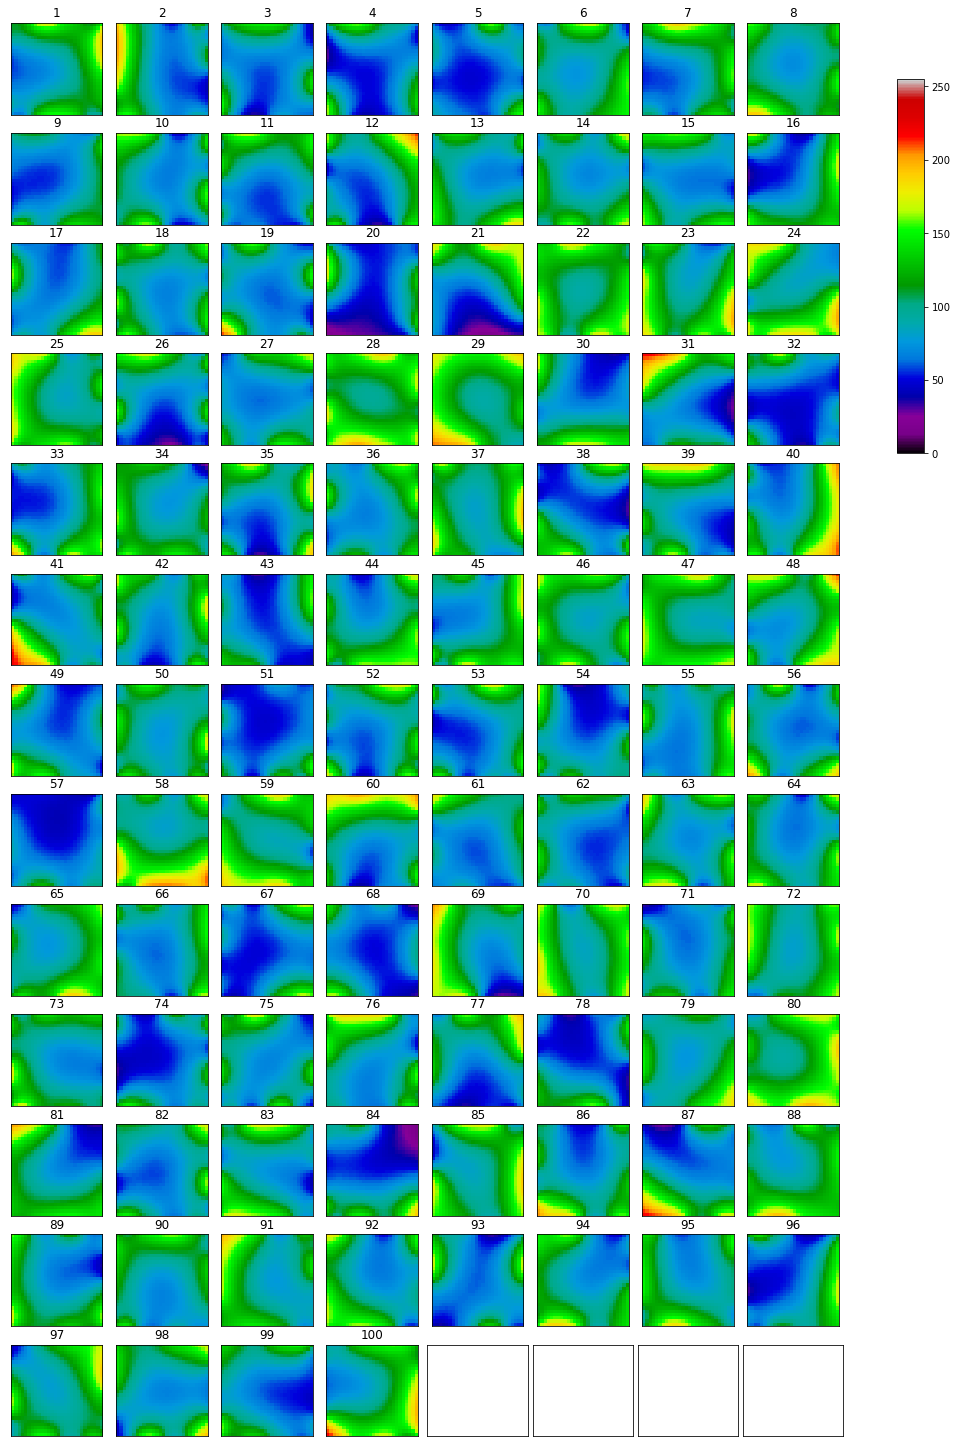

SystemExit: 0

/anaconda/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import yaml

def read_csv_file(csvfile, xsize, ysize): 
    num_rows = len(open(csvfile, "r").readlines())
    f = open(csvfile, "r")
    data_2d = np.zeros((num_rows, xsize, ysize))
    
    print("number of rows in csvfile", num_rows)
    print("caseNo, row, col: ", data_2d.shape)
    
    reader = csv.reader(f)
    n = 0
    for row in reader:
        k = 0
        j = 0
        for j in range(ysize):
            i = 0
            for i in range(xsize):
                k = j * xsize + i
                data_2d[n][j][i] = row[k]
                i+=1
            j+=1
        n+=1
    f.close()
    return data_2d

def visualize_data(area, xsize, ysize):  

    #xsize,ysize,num_data のnum_data要素数を取得
    num_data = area.shape[0]
    
    num_cols = 8
    num_rows = int(num_data / num_cols)
    
    if num_data % num_cols != 0:
        num_rows += 1
    
    print("num_data: ", num_data)
    print("num_rows: ", num_rows)
    print("num_cols: ", num_cols)
    
    fig, axes = plt.subplots(num_rows, num_cols, 
                             figsize=(15, num_rows * 2), 
                             subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.2, wspace=0.05)

    for ax, icase in zip(axes.flat, range(num_data)):
        #print(ax)
        im = ax.imshow(area[icase], interpolation="none", cmap='nipy_spectral', vmin=0, vmax=255)
        ax.set_title(icase+1)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.65, 0.025, 0.2])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

    
    
if __name__ == '__main__':
    inputfile = "./input.yml"
    f = open(inputfile, "r+")
    input_data = yaml.load(f)
    X_SOLVE = input_data['X_SOLVE']
    Y_SOLVE = input_data['Y_SOLVE']
    X_CUT = input_data['X_CUT']
    Y_CUT = input_data['Y_CUT']
    X_BOUND = input_data['X_BOUND']
    Y_BOUND = input_data['Y_BOUND']
    
    # all regions including boundary condition
    x_size = X_SOLVE + 2 * X_BOUND
    y_size = Y_SOLVE + 2 * Y_BOUND
    
    imin = X_BOUND
    imax = x_size - X_BOUND
    jmin = Y_BOUND
    jmax = y_size - Y_BOUND
    
    data_2d = read_csv_file('training_data.csv', X_CUT, Y_CUT)
    visualize_data(data_2d, X_CUT, Y_CUT)
    sys.exit(0)
    

# 参考
http://www.turbare.net/transl/scipy-lecture-notes/intro/matplotlib/auto_examples/plot_imshow_ex.html
https://matplotlib.org/examples/images_contours_and_fields/interpolation_methods.html

In [ ]:
%%bash
pwd